У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 53.4 MB/s eta 0:

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from darts import TimeSeries

In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Machine Learning/Data/time_series.csv")

Mounted at /content/drive


In [34]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



In [9]:
import plotly.graph_objects as go
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.display import display

# Calculate average, min, and max sales for each item over time
summary = df.groupby(['date', 'item']).agg(
    avg_sales=('sales', 'mean'),
    min_sales=('sales', 'min'),
    max_sales=('sales', 'max')
).reset_index()

output = widgets.Output()

# Function to create an interactive plot for a selected item
def create_interactive_plot(item):
    item_data = summary[summary['item'] == item]

    fig = go.Figure()

    # Add the average sales line
    fig.add_trace(go.Scatter(
        x=item_data['date'],
        y=item_data['avg_sales'],
        mode='lines',
        name='Average Sales'
    ))

    # Add the range (min to max sales)
    fig.add_trace(go.Scatter(
        x=item_data['date'].tolist() + item_data['date'].tolist()[::-1],
        y=item_data['max_sales'].tolist() + item_data['min_sales'].tolist()[::-1],
        fill='toself',
        fillcolor='rgba(173,216,230,0.3)',
        line_color='rgba(255,255,255,0)',
        showlegend=True,
        name='Sales Range'
    ))

    fig.update_layout(
        title=f'Sales Dynamics for item {item}',
        xaxis_title='Date',
        yaxis_title='Sales',
        template='plotly_white'
    )

    fig.show()

# Dropdown widget for item selection
item_dropdown = widgets.Dropdown(
    options=summary['item'].unique(),
    description='Select Item:',
    style={'description_width': 'initial'}
)

# Update function to refresh the plot based on selected item
def update_plot(change):
    clear_output(wait=True)
    create_interactive_plot(change['new'])
    display(item_dropdown)

# Link the dropdown selection to the update function
item_dropdown.observe(update_plot, names='value')

# Initialize with the first item selected
create_interactive_plot(summary['item'].unique()[0])

# Display the dropdown widget
display(item_dropdown)

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Dropdown(description='Select Item:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1…

Спостереження:

У даних про продажі є сезонна тенденція. Продажі збільшуються та зменшуються протягом річного циклу. Видно піки та спади, що вказують на періоди високих і низьких продажів.

Спостерігається загальна тенденція до зростання середніх продажів з часом.

Область, що представляє діапазон (від мінімального до максимального) продажів, показує значну варіацію навколо лінії середніх продажів. Також, схоже, ця варіація збільшується в періоди високих продажів.

Також на графіках помітні сплески продажів, які можуть бути пов’язані з певними подіями, святами чи акціями.

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [5]:
df_1_1 = df[(df.item==1) & (df.store==1)]
df_1_1.head(5)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


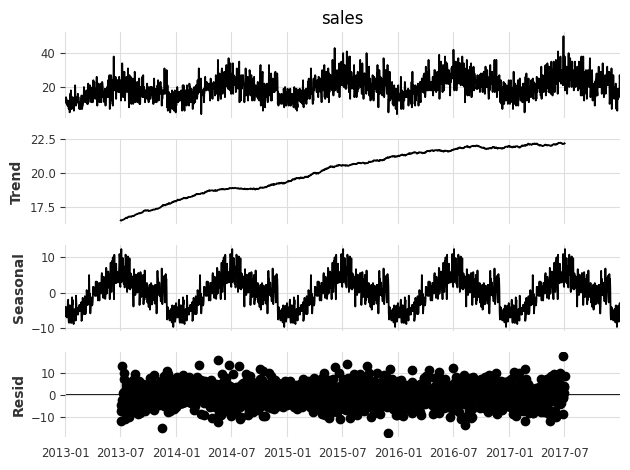

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_plot_multi = seasonal_decompose(df_1_1.sales, period=365, model='additive')
decomposition_plot_multi.plot()
plt.show()

З цієї декомпозиції бачимо чіткий паттерн сезонності і тренд до зростання, залишки не мають паттерну і зосереджені навколо 0, але мають доволі велику варіативність.

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [6]:
series = TimeSeries.from_dataframe(df_1_1, value_cols='sales')

In [13]:
series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

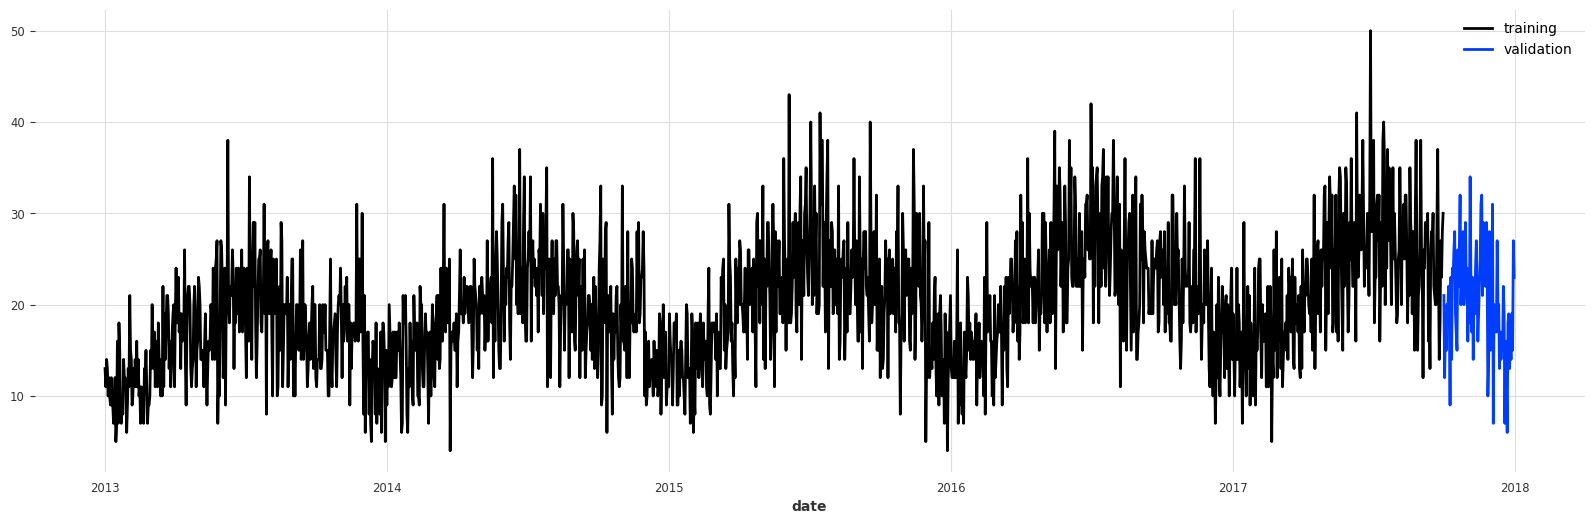

In [7]:
train, val = series.split_before(pd.Timestamp("2017-10-01"))

plt.figure(figsize=(20,6))
train.plot(label="training")
val.plot(label="validation")

plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

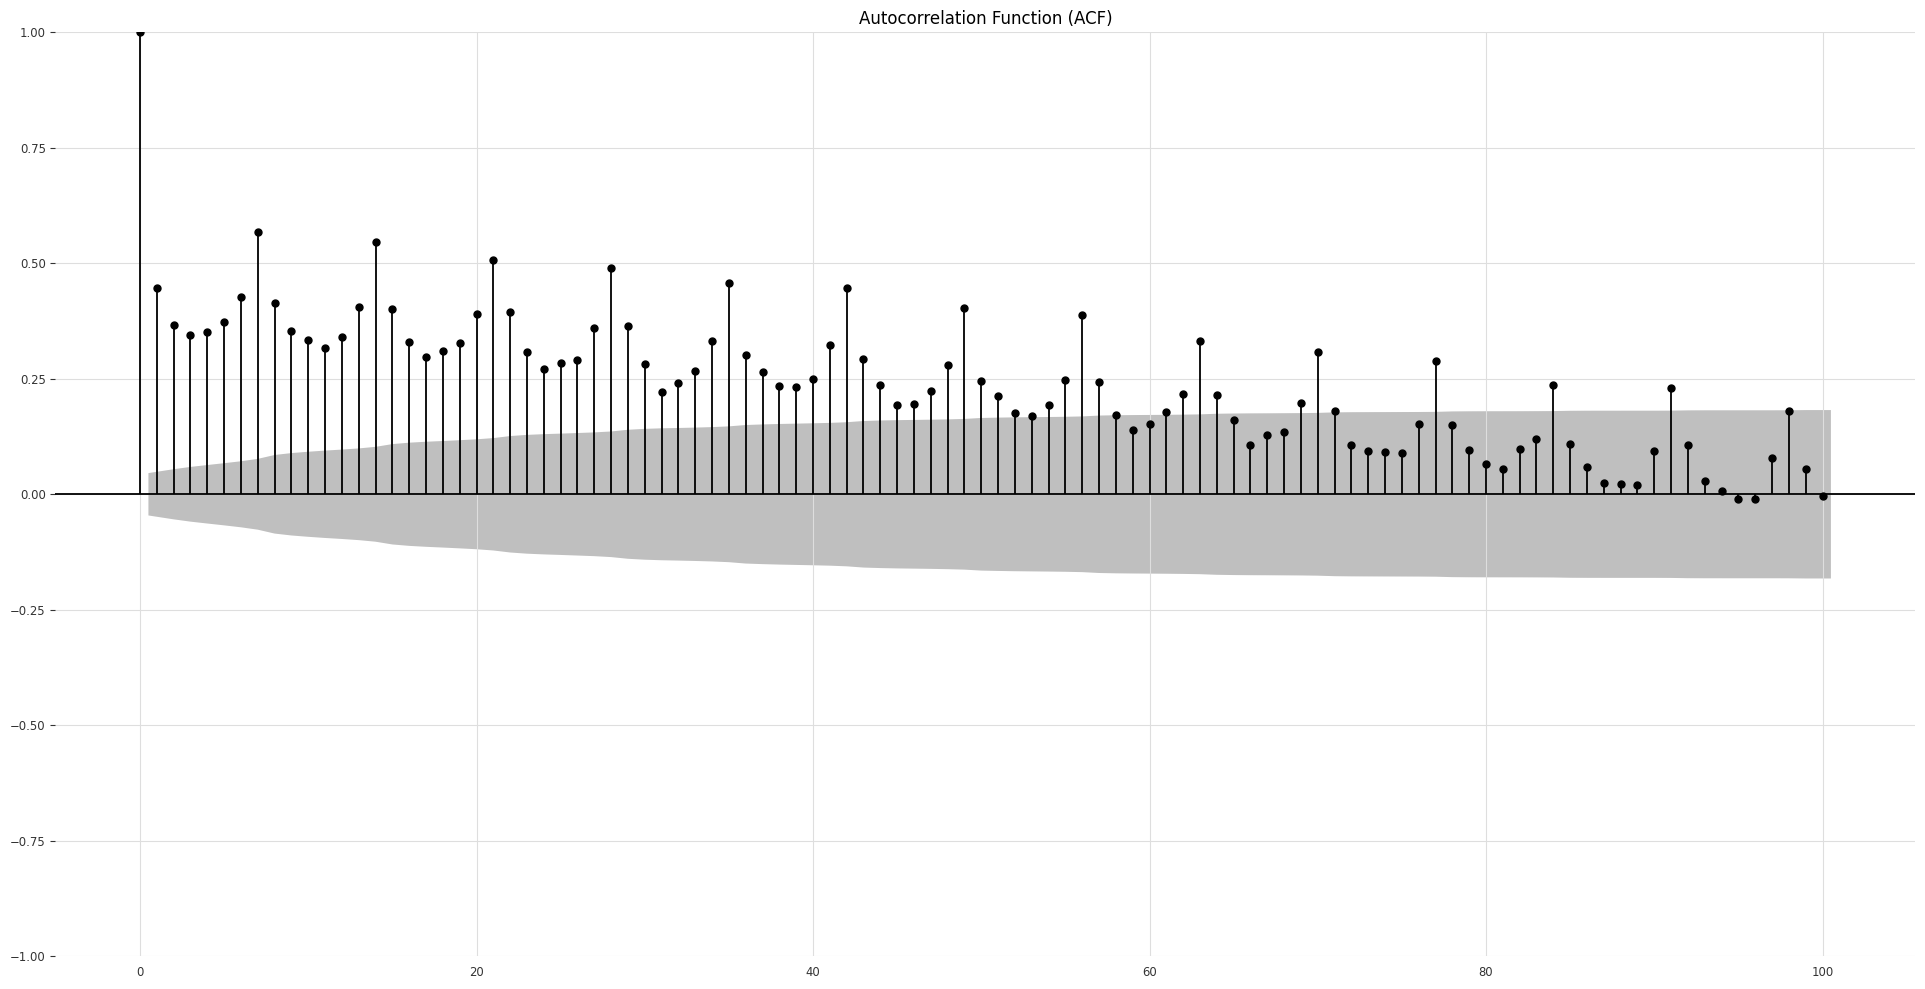

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(24, 12))
plot_acf(df_1_1.sales, lags=100, ax=ax)
plt.title('Autocorrelation Function (ACF)')

plt.show();

Спостереження:

Помітні піки через рівні проміжки часу (наприклад, на лагах 7, 14, 21, etc), що вказує на тижневу сезонність даних. Це говорить про те, що модель продажів може повторюватися щотижня.

Значення автокореляції поступово зменшуються зі збільшенням лагу, але той факт, що воно лишається статистично значущим навіть на великих лагах (майже до 60), вказує на те, що минулі значення продовжують мати певний вплив протягом доволі тривалого періоду, хоча він і зменшується з часом.

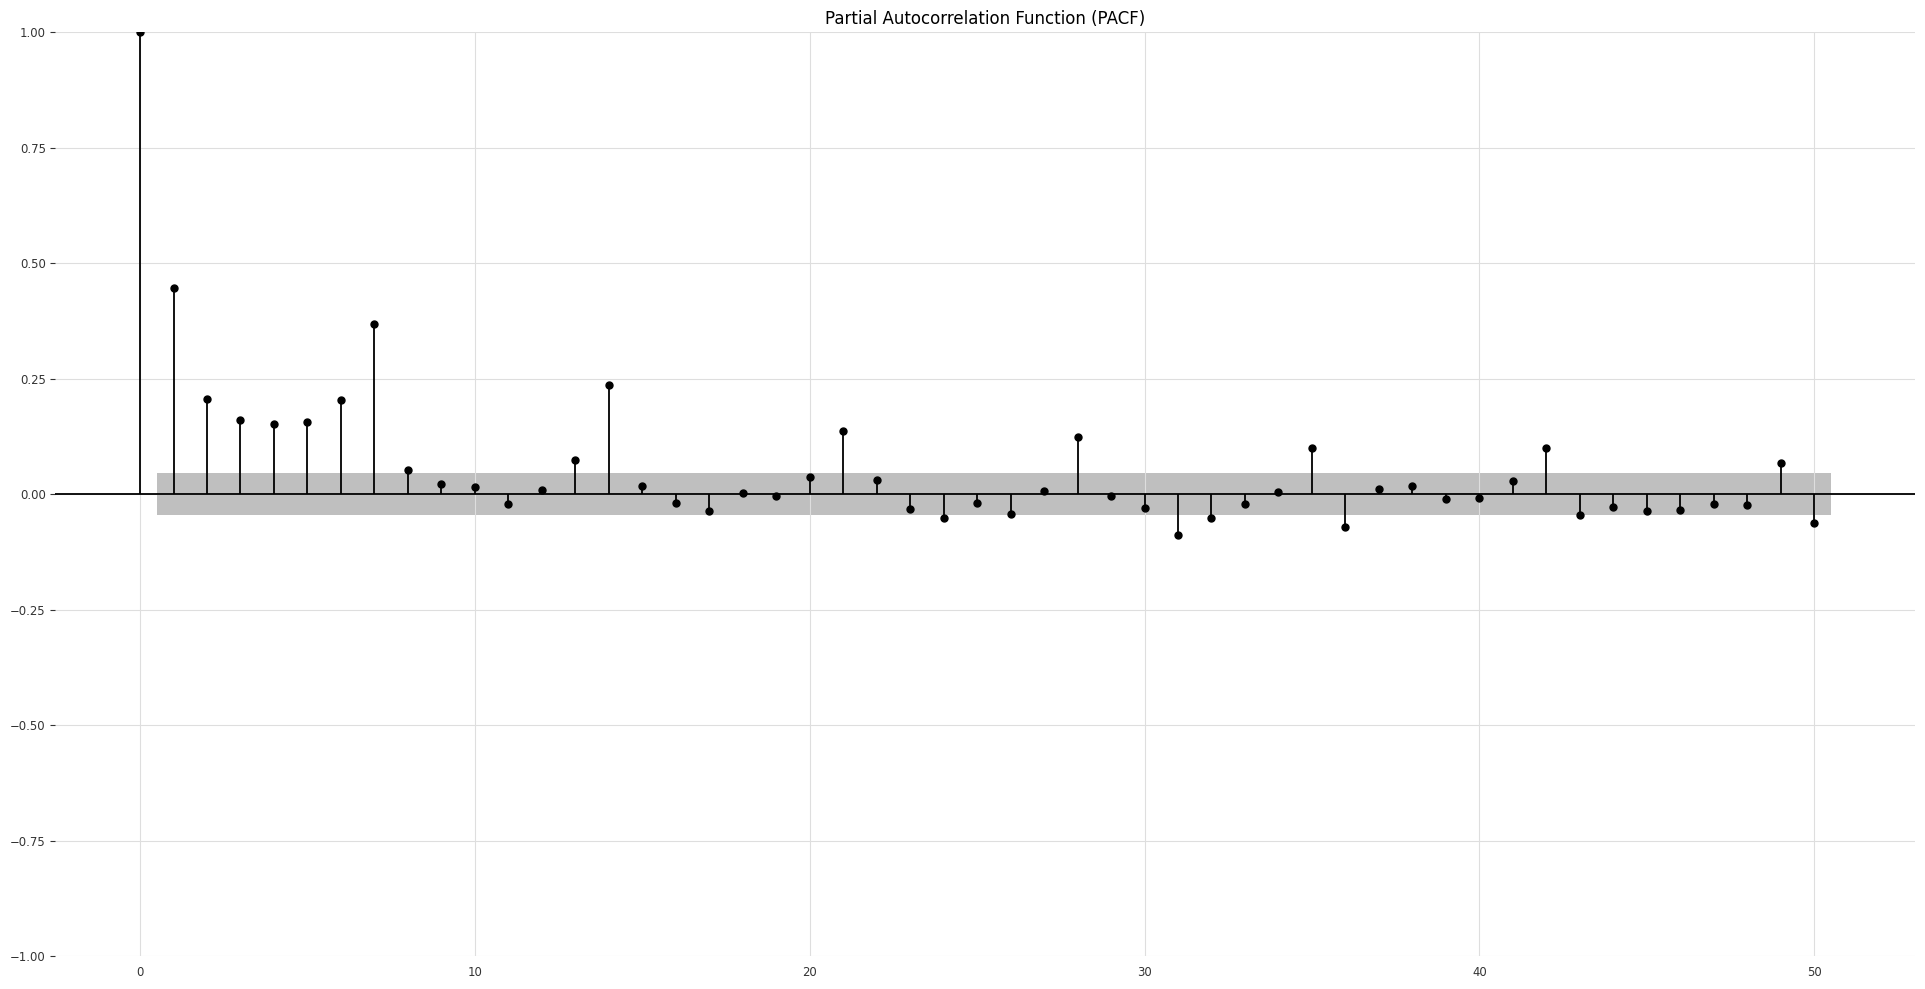

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(24, 12))
plot_pacf(df_1_1.sales, lags=50, method='ywm', ax=ax)
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()

Значущі значення на лагах 7, 14, 21, etc на графіку PACF підтверджують, що кореляція на цих лагах залишається значущою, навіть усунувши вплив проміжних лагів.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [16]:
from darts.utils.statistics import check_seasonality

for m in range(2, 400):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05, max_lag=400)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.
There is seasonality of order 28.
There is seasonality of order 35.
There is seasonality of order 42.
There is seasonality of order 49.
There is seasonality of order 56.
There is seasonality of order 63.
There is seasonality of order 70.
There is seasonality of order 74.
There is seasonality of order 77.
There is seasonality of order 84.
There is seasonality of order 91.
There is seasonality of order 98.
There is seasonality of order 105.
There is seasonality of order 112.
There is seasonality of order 119.
There is seasonality of order 126.
There is seasonality of order 133.
There is seasonality of order 224.
There is seasonality of order 231.
There is seasonality of order 238.
There is seasonality of order 245.
There is seasonality of order 252.
There is seasonality of order 259.
There is seasonality of order 266.
There is seasonality of order 273.
There is seasonality of order 280.
T

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

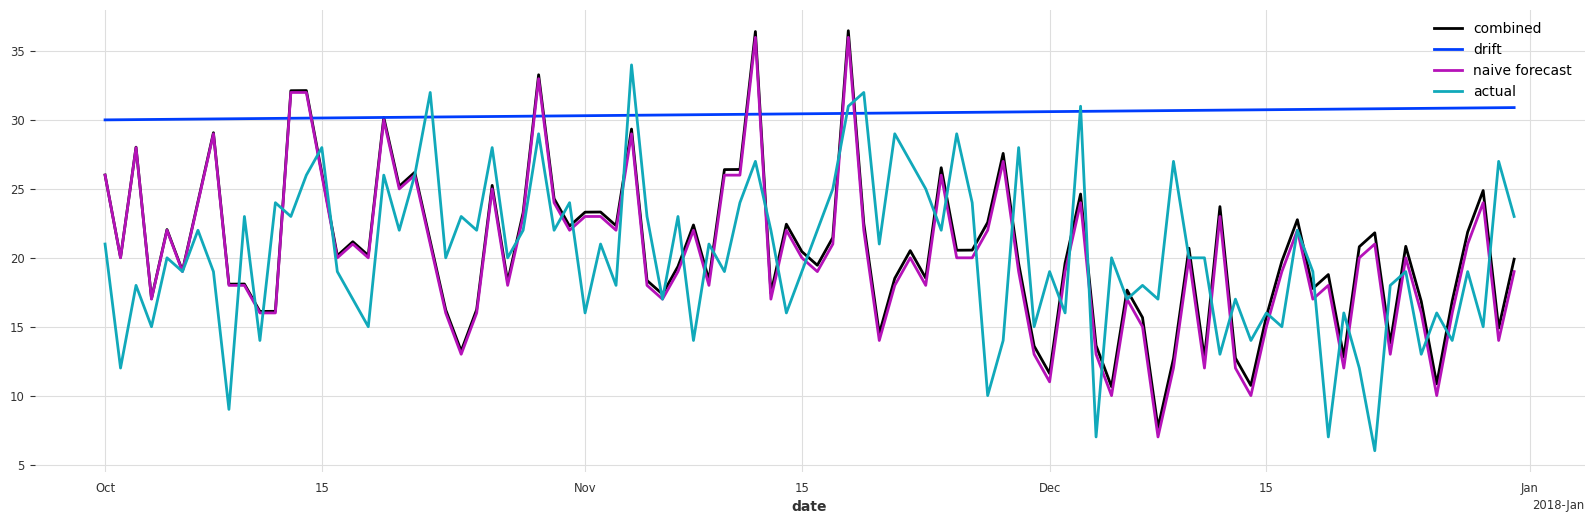

In [27]:
from darts.models import NaiveSeasonal, NaiveDrift
from darts.metrics import mape

plt.figure(figsize=(20,6))

naive_model = NaiveSeasonal(K=364)
naive_model.fit(train)
naive_forecast = naive_model.predict(len(val))

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(val))

combined_forecast = drift_forecast + naive_forecast - train.last_value()

combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")
naive_forecast.plot(label="naive forecast")
val.plot(label="actual")

plt.show()

Наївна модель, схоже, частково фіксує сезонність наявну у даних, на це вказують піки та спади, які  нагадують фактичні дані, однак вони не співпадають ідеально, є суттєві відхилення. Загалом, думаю, цю модель можна було б використовувати як baseline.

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [29]:
def eval_forecast(val, forecast):
  mape_ = mape(val, forecast)
  print(f"Model obtains MAPE: {mape_:.2f}%")
  return mape_

eval_forecast(val, combined_forecast)

Model obtains MAPE: 32.21%


32.20862438117553

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [ ]:
from darts.models import XGBModel

# Enrich the dataset with date features
def enrich_with_date_features(df):
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['quarter'] = df.index.quarter
    df['weekofyear'] = df.index.isocalendar().week
    return df

# Enrich with date features
df_1_1 = enrich_with_date_features(df_1_1)

# Create TimeSeries object for covariates
covariates = TimeSeries.from_dataframe(df_1_1, value_cols=['day', 'month', 'year', 'dayofweek', 'dayofyear', 'quarter', 'weekofyear'])

# Split covariates into train and validation sets
cov_train, cov_val = covariates.split_before(pd.Timestamp("2017-09-30"))

# Initialize and train the XGBoost model
xgb = XGBModel(
    lags=[-1,-7,-365,-730],
    lags_past_covariates=[-1],
    output_chunk_length=1,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

# Fit the model
xgb.fit(series=train, past_covariates=cov_train)

# Make predictions
forecast = xgb.predict(len(val), past_covariates=cov_val)

In [13]:
def plot_forecast(val, forecast):
  plt.figure(figsize=(20,6))

  val.plot(label='Actual')
  forecast.plot(label='Forecast')

  plt.legend()
  plt.show()

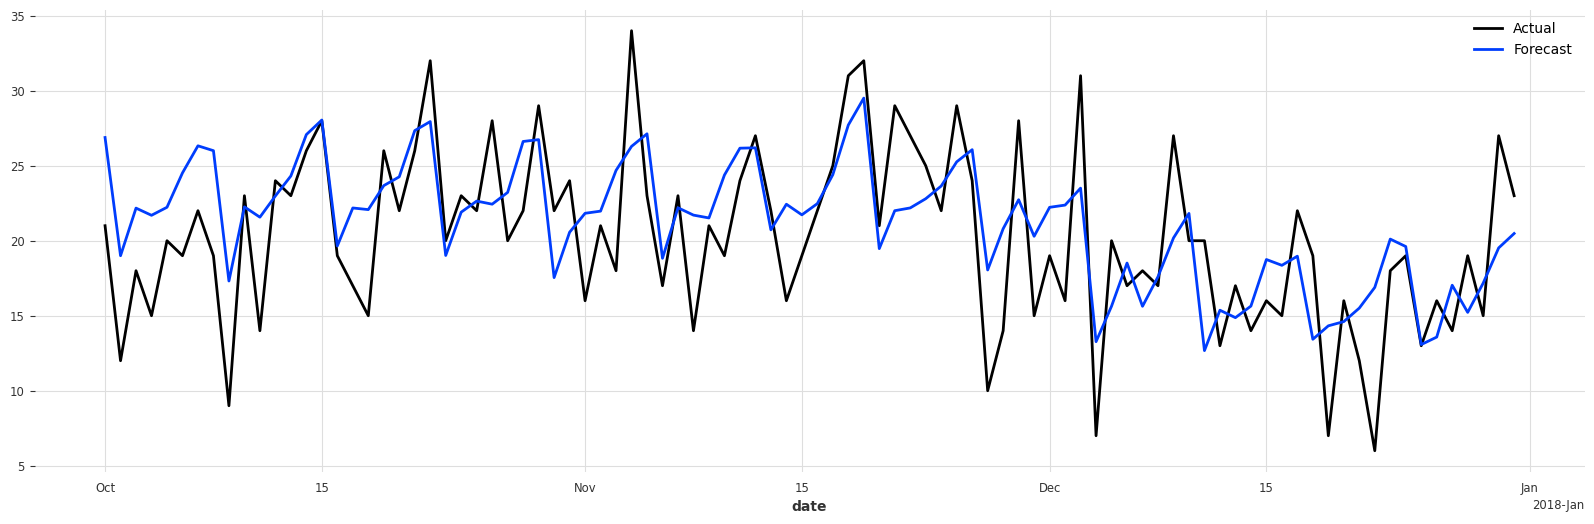

Model obtains MAPE: 22.75%


22.748978142606635

In [194]:
plot_forecast(val, forecast)
eval_forecast(val, forecast)

Ця модель покращилась на цілих 10% в порівнянні з наївною моделлю, вона відносно добре справляється з прогнозуванням загальної тенденції та напрямку, фіксує загальні підйоми та падіння, але не вгадує величину піків і спадів.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

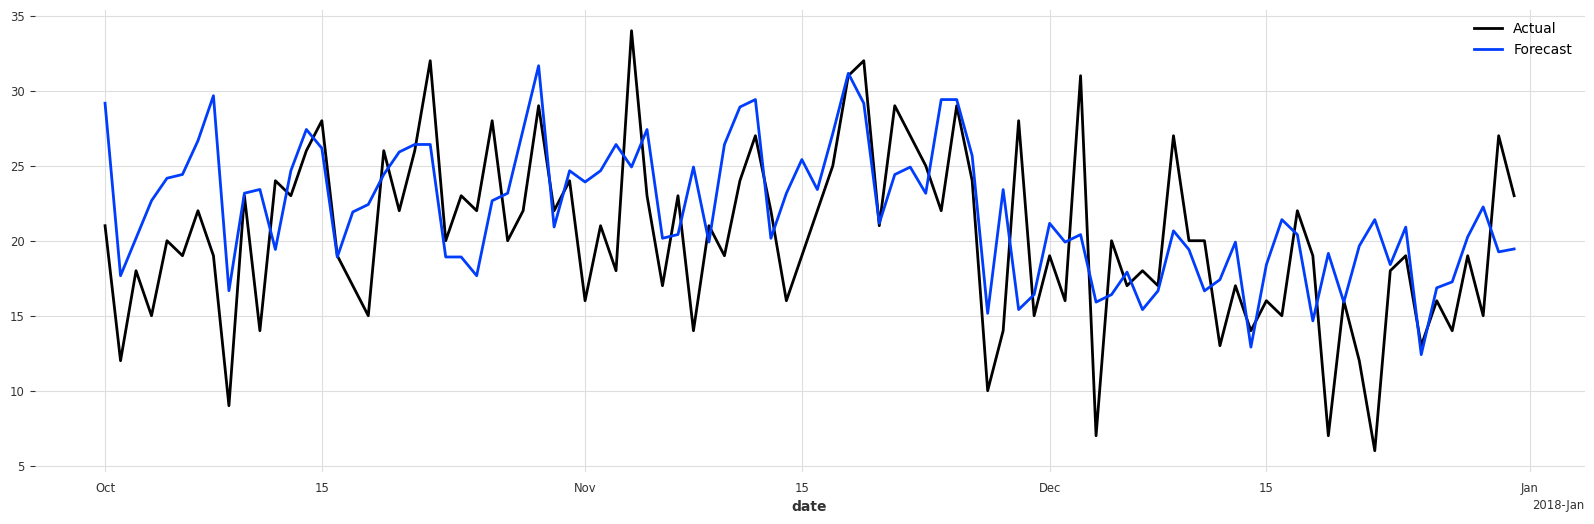

Model obtains MAPE: 26.89%


26.88924250136698

In [154]:
from darts.models import ExponentialSmoothing

es = ExponentialSmoothing(seasonal_periods=364)
es.fit(train)
forecast = es.predict(len(val))

plot_forecast(val, forecast)
eval_forecast(val, forecast)

Ця модель по якості є середньою між наївною і XGBoost, загальний тренд вона вгадує, але доволі суттєво помиляється.

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

Виконаємо ADF тест:

In [164]:
from statsmodels.tsa.stattools import adfuller

# Виконання ADF тесту
result = adfuller(df_1_1['sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.157671
p-value: 0.022569


За результатами тесту ряд є стаціонарним на рівні значущості 0.05, отже його не потрібно диференціювати і значення d буде дорівнювати 0.

Для пошуку значення p використаємо PACF plot, p дорівнюватиме значенню лагу в точці, де графік PACF вперше сильно наближається або перетинає верхній довірчий інтервал, тобто p = 8.

Для пошуку значення q використаємо ACF plot, q дорівнюватиме значенню лагу в точці, де графік ACF вперше сильно наближається або перетинає верхній довірчий інтервал, тобто q = 52.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



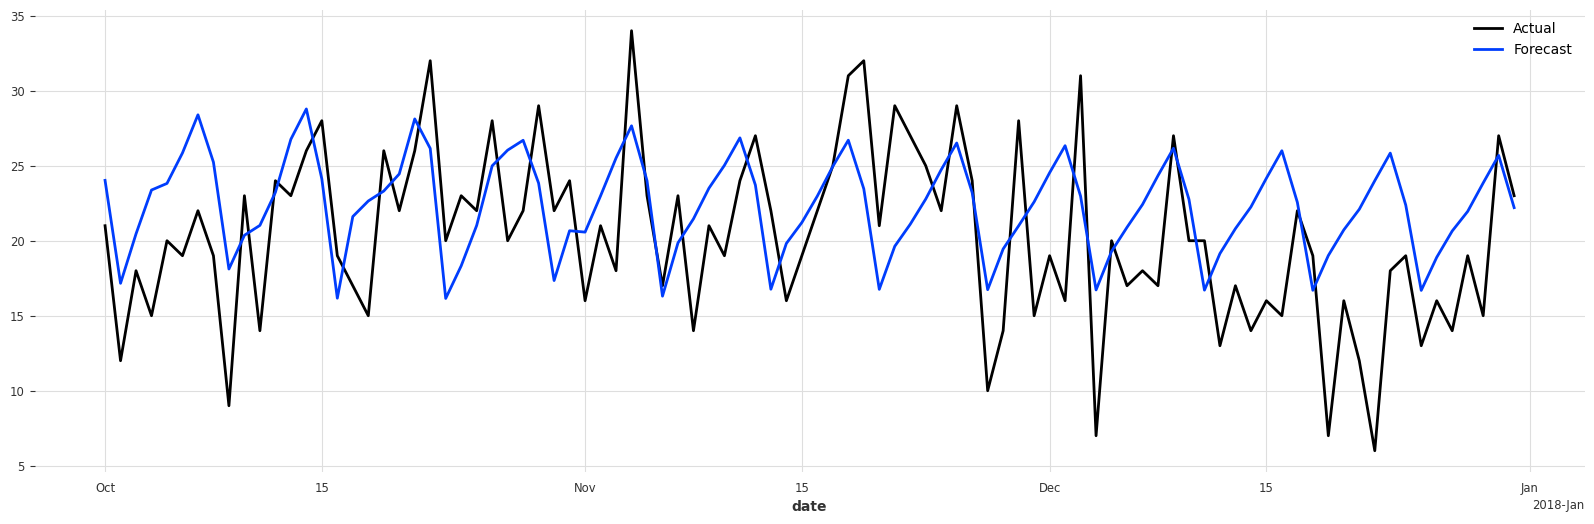

Model obtains MAPE: 31.13%


31.12758768364006

In [163]:
from darts.models import ARIMA

# Побудова та тренування моделі ARIMA
model = ARIMA(p=8, d=0, q=52)
model.fit(train)
forecast = model.predict(len(val))

plot_forecast(val, forecast)
eval_forecast(val, forecast)

Ця модель помітила лише тижневий тренд, при цьому в різні місяці її прогнози практично не відрізняються.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

AutoARIMA(add_encoders=None, start_p=7, max_p=21, start_q=40, max_q=55)

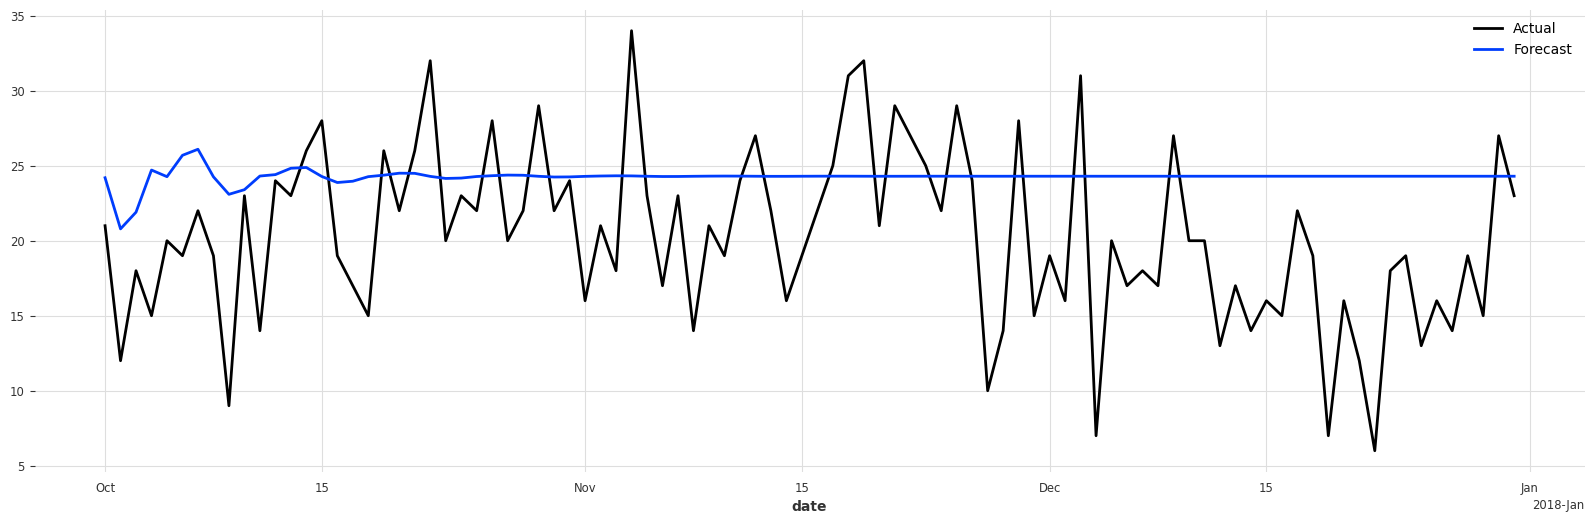

Model obtains MAPE: 39.53%


39.52818304458719

In [165]:
from darts.models import AutoARIMA

model = AutoARIMA(start_p=7, max_p=21, start_q=40, max_q=55)
model.fit(train)

display(model)

forecast = model.predict(len(val))

plot_forecast(val, forecast)
eval_forecast(val, forecast)

In [166]:
model.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1734
Model:               SARIMAX(7, 1, 1)   Log Likelihood               -5286.539
Date:                Wed, 14 Aug 2024   AIC                          10591.078
Time:                        10:39:16   BIC                          10640.196
Sample:                             0   HQIC                         10609.244
                               - 1734                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0346      0.038      0.904      0.366      -0.040       0.109
ar.L2         -0.0799      0.034     -2.379      0.017      -0.146      -0.014
ar.L3         -0.0775      0.033     -2.316      0.021      -0.143      -0.012
ar.L4         -0.0651      0.034     -1.939      0.053      -0.131       0.001
ar.L5         -0.0342      0.032     -1.063      0.288      -0.097       0.029
ar.L6          0.0062      0.030      0.207      0.836      -0.053       0.065
ar.L7          0.2638      0.029      9.042      0.000       0.207       0.321
ma.L1         -0.9071      0.026    -34.233      0.000      -0.959      -0.855
sigma2        26.0956      0.820     31.811      0.000      24.488      27.703
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ця модель взагалі передбачила константу після 2 тижнів (хоча і перші 2 тижні вона не вгадала тренд).

14. Натренуйте модель Prophet та зробіть висновок про її якість.

In [ ]:
from darts.models import Prophet

# Побудова та тренування моделі Prophet
prophet = Prophet(country_holidays='US')
prophet.fit(train)

# Прогнозування
forecast = prophet.predict(len(val))

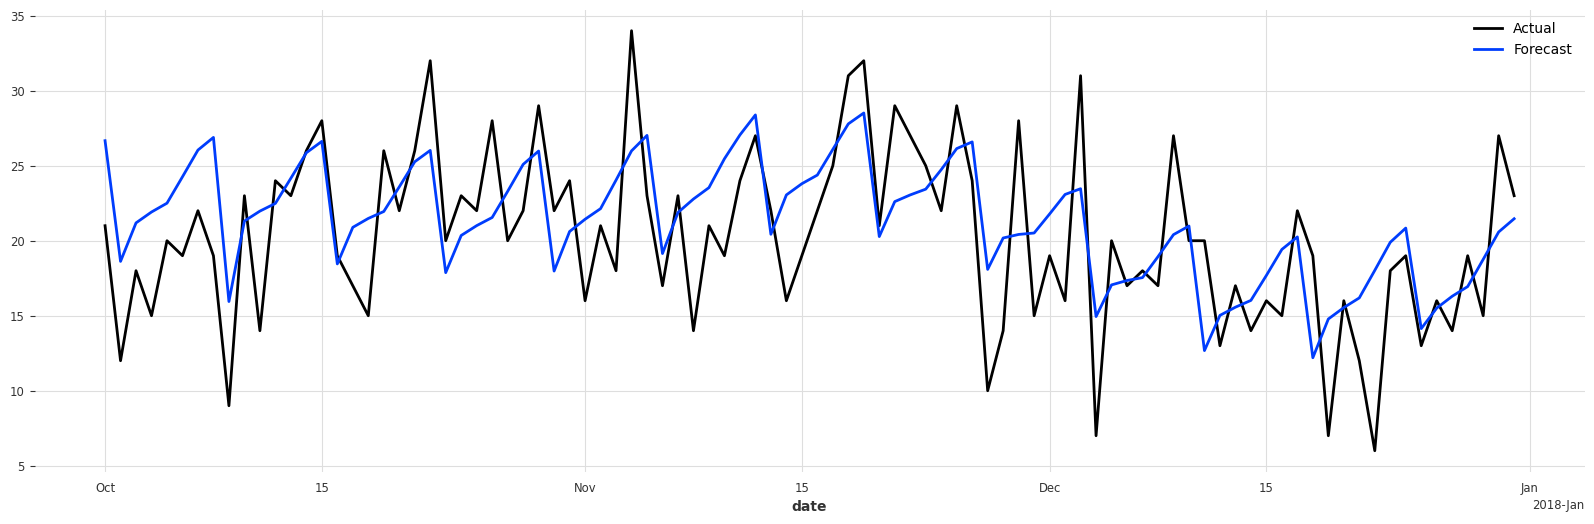

Model obtains MAPE: 23.47%


23.474921778114346

In [214]:
plot_forecast(val, forecast)
eval_forecast(val, forecast)

Ця модель видає дуже подібний результат до XGBoost при цьому з мінімальними налаштуваннями.

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [ ]:
from darts.models import RNNModel

rnn = RNNModel(
    input_chunk_length=365,
    output_chunk_length=1,
    n_rnn_layers=2,
    hidden_dim=50,
    dropout=0.2,
    batch_size=64,
    training_length=365,
    n_epochs=100,
    random_state=42,
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": 1
    }
)

rnn.fit(train)

# Прогнозування
forecast = rnn.predict(len(val))

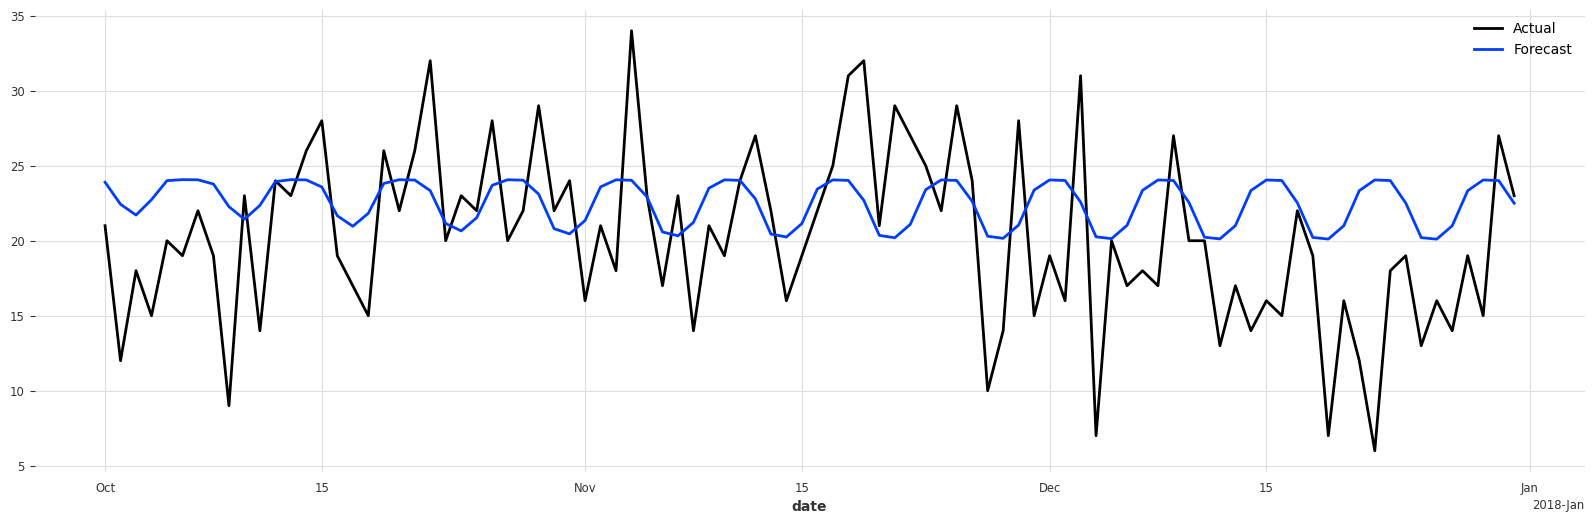

Model obtains MAPE: 32.42%


32.418660857825905

In [27]:
plot_forecast(val, forecast)
eval_forecast(val, forecast)

Ця модель побачила тільки тижневий тренд, а річний - зовсім ні, тому результати вийшли не точні.

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

XGBoost та Prophet показали дуже подібні результати на валідаційних даних, тож виконаємо backtest на обох.

Prophet:

In [ ]:
hfc_params = {
    "series": series,
    "start": pd.Timestamp("2016-12-01"),
    "forecast_horizon": 30,
    "verbose": True,
}

historical_fcast = prophet.historical_forecasts(last_points_only=True, **hfc_params)

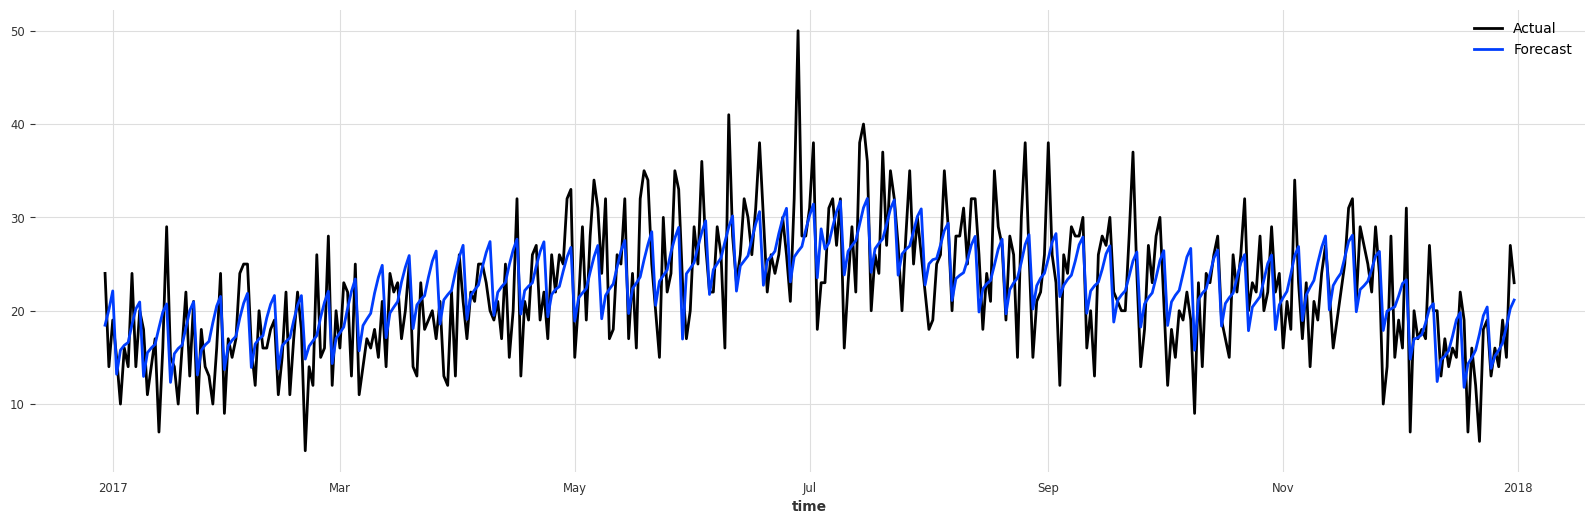

Model obtains MAPE: 21.25%


21.249245763719

In [191]:
actual_before, actual_after = series.split_before(pd.Timestamp("2016-12-30"))

plot_forecast(actual_after, historical_fcast)
eval_forecast(actual_after, historical_fcast)

XGBoost:

In [ ]:
cov_before, cov_after = covariates.split_before(pd.Timestamp("2016-11-30"))

historical_fcast_xgb = xgb.historical_forecasts(last_points_only=True, **hfc_params, past_covariates = cov_after)

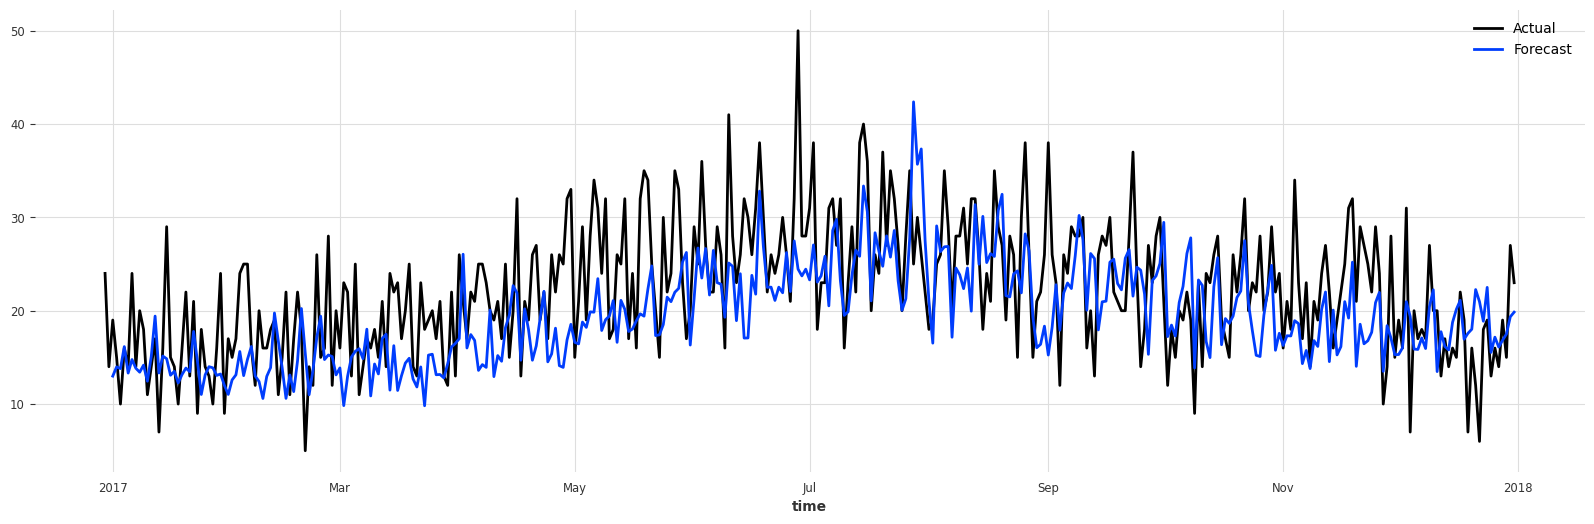

Model obtains MAPE: 24.67%


24.67206240910652

In [207]:
plot_forecast(actual_after, historical_fcast_xgb)
eval_forecast(actual_after, historical_fcast_xgb)

Бачимо, що Prophet видає кращі результати на backtest'і.

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Подивимось, наскільки адекватно перформить наша найкраща модель (Prophet) на інших даних:

In [ ]:
items = df.item.unique()
stores = df.store.unique()

mape_dict = {}
for i in items:
  for s in stores:
    df_temp = df[(df.item==i) & (df.store==s)]
    series_temp = TimeSeries.from_dataframe(df_temp, value_cols='sales')
    train_temp, val_temp = series_temp.split_before(pd.Timestamp("2017-10-01"))
    prophet = Prophet(country_holidays='US')
    prophet.fit(train_temp)
    forecast = prophet.predict(len(val_temp))
    mape_dict[(i, s)] = eval_forecast(val_temp, forecast)

In [247]:
sorted(mape_dict.items(), key=lambda x: x[1])

[((22, 2), 6.993156711206583),
 ((15, 2), 8.170002444929667),
 ((28, 10), 8.307078033608603),
 ((18, 10), 8.44759528241934),
 ((13, 10), 8.50336406411261),
 ((18, 2), 8.660472088613151),
 ((28, 9), 8.764058535682002),
 ((38, 8), 8.876172685677465),
 ((15, 4), 9.009908583932313),
 ((24, 2), 9.142098541221179),
 ((22, 10), 9.149703825242689),
 ((36, 10), 9.151424654655978),
 ((15, 8), 9.244213878511836),
 ((36, 8), 9.247011457808524),
 ((38, 2), 9.30161506963766),
 ((38, 3), 9.354007640306907),
 ((31, 8), 9.388372014572859),
 ((35, 3), 9.410032689587949),
 ((11, 9), 9.423598318954902),
 ((10, 8), 9.42657605994928),
 ((11, 8), 9.426877540693793),
 ((8, 2), 9.442700602376048),
 ((2, 3), 9.450276800623522),
 ((11, 10), 9.485916805509389),
 ((28, 2), 9.48807799960719),
 ((25, 8), 9.50000042708934),
 ((13, 3), 9.51691074252168),
 ((22, 8), 9.566560125904289),
 ((35, 10), 9.568717131172088),
 ((25, 3), 9.591720719804737),
 ((46, 3), 9.597693573705481),
 ((24, 8), 9.601865342850282),
 ((13, 4),

Бачимо, що на більшій частині даних Prophet перформить навіть краще ніж на даних, з якими ми працювали (item == 1, store == 1), на їх значній частині - навіть набагато краще. Тож як мінімум можна було би використати ці моделі, оскільки вони дуже швидко тренуються і не потребують додаткових налаштувань (хіба що, можна було би дослідити, чому на деяких даних гірший перформанс, можливо, там є сезонність, яка не врахована в дефолтних налаштуваннях Prophet'a). Також я б дослідила, як можна агрегувати / зкомбінувати результати різних моделей.